<a href="https://colab.research.google.com/github/stefanogiagu/corso_AI_2022/blob/main/notebooks/es7/SuperSimpleMLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Implementation of a basic pytroch MLP shallow architecture
# Stefano Giagu - v1.0 - 9.2.2022

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

1.11.0+cu113
0.12.0+cu113


In [3]:
if torch.cuda.is_available():
  print(torch.cuda.device_count())
  print(torch.cuda.get_device_name(0))

device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

1
Tesla P100-PCIE-16GB
Computation device: cuda



In [4]:
# toy dataset generated with numpy
# 4 uncorrelated features gaussian distributed and with different means

features_S = np.random.normal(loc=[1.,2.,3.,4.], scale=0.3, size=(2000,4))
features_B = np.random.normal(loc=[1.5,2.2,3.,4.2], scale=0.3, size=(2000,4))
labels_S = np.zeros(shape=(2000))
labels_B = np.ones(shape=(2000))

X = np.concatenate((features_S, features_B), axis=0)
Y = np.concatenate((labels_S, labels_B), axis=0)

# divide the dataset in train and test
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=12345)
X_train, X_vali, Y_train, Y_vali = train_test_split(X_train, Y_train, test_size=0.2, random_state=456789)
print(X_train.shape)
print(Y_train.shape)
print(X_vali.shape)
print(Y_vali.shape)
print(X_test.shape)
print(Y_test.shape)

(2560, 4)
(2560,)
(640, 4)
(640,)
(800, 4)
(800,)


In [5]:
# Normalization of the input feature
# let's normalize them by scaling everything in [0,1] (alternatively subtract mean and divide by sdev)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_vali = scaler.transform(X_vali)
X_test = scaler.transform(X_test) #note: scaling parameters for the validation and test set taken from the trainig set

In [6]:
# transform the numpy arrays to pytorch tensors

X_train_pt = torch.Tensor(X_train).float()
Y_train_pt = torch.Tensor(Y_train).float()
X_vali_pt = torch.Tensor(X_vali).float()
Y_vali_pt = torch.Tensor(Y_vali).float()
X_test_pt = torch.Tensor(X_test).float()
Y_test_pt = torch.Tensor(Y_test).float()


print(X_train_pt.shape)
print(Y_train_pt.shape)
print(X_vali_pt.shape)
print(Y_vali_pt.shape)
print(X_test_pt.shape)
print(Y_test_pt.shape)

# create a poytorch dataloader (a python iterable that allows to iterate among sample's events 
# mini-batch it, reshuffle at every epoch, etc...)
from torch.utils.data import TensorDataset, DataLoader

dataset_train = TensorDataset(X_train_pt, Y_train_pt) 
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True) 

dataset_vali = TensorDataset(X_vali_pt, Y_vali_pt) 
dataloader_vali = DataLoader(dataset_vali, batch_size=32, shuffle=True) 

torch.Size([2560, 4])
torch.Size([2560])
torch.Size([640, 4])
torch.Size([640])
torch.Size([800, 4])
torch.Size([800])


In [7]:
# example of iteration through the dataloader

train_features, train_labels = next(iter(dataloader_train))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

an_event = train_features[0].squeeze()
a_label = train_labels[0]

print(f"Feature: {an_event}")
print(f"Label: {a_label}")

Feature batch shape: torch.Size([32, 4])
Labels batch shape: torch.Size([32])
Feature: tensor([0.2718, 0.2466, 0.5362, 0.1289])
Label: 0.0


In [8]:
from torch import nn
import torch.nn.functional as F

# architetture: MLP shallow with a dense layer with 20 neurons
class ShallowMLP(nn.Module):
  def __init__(self):
    super(ShallowMLP, self).__init__()
    
    #torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
    #Linear in pytroch is the equivalent of Dense in keras
    self.layer1 = nn.Linear(4, 20)
    self.activ1 = nn.ReLU()
    self.layer2 = nn.Linear(20, 1)
    self.activ2 = nn.Sigmoid()
    
  def forward(self, x):
    out = self.layer1(x)
    out = self.activ1(out)
    out = self.layer2(out)
    out = self.activ2(out)
    return out

In [9]:
%pip install torchsummary

In [10]:
model = ShallowMLP()
print(model)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model.cuda(), input_size=(1,4))
else:
  summary(model, input_size=(1,4))

ShallowMLP(
  (layer1): Linear(in_features=4, out_features=20, bias=True)
  (activ1): ReLU()
  (layer2): Linear(in_features=20, out_features=1, bias=True)
  (activ2): Sigmoid()
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 20]             100
              ReLU-2                [-1, 1, 20]               0
            Linear-3                 [-1, 1, 1]              21
           Sigmoid-4                 [-1, 1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [11]:
#loss 
loss_func = nn.BCELoss() #binary cross entropy loss

#metric accuracy
def accuracy(out, yb):
    preds = out.reshape(-1).detach().numpy().round()
    return (preds == yb.detach().numpy()).mean()

metric_func = accuracy

# optim
from torch import optim
opt = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [12]:
print(next(model.parameters()).device)
model.to(device)
print(next(model.parameters()).device)

cuda:0
cuda:0


In [17]:
#training
import time
epochs = 100

hist_loss = []
hist_metric = []
hist_vloss = []
hist_vmetric = []

for epoch in range(epochs):
    t0 = time.time()
    
    #training step
    model.train()
    train_loss = 0.0
    train_metric = 0.0
    counter = 0
    for xb, yb in dataloader_train:
        counter += 1
        xb=xb.type(torch.float).to(device)
        yb=yb.type(torch.float).to(device)
        pred = model(xb)
        loss = loss_func(pred, torch.unsqueeze(yb,1))
        metric = metric_func(pred.cpu(), yb.cpu())
        train_loss += loss.item()
        train_metric += metric.item()

        # backpropagation
        loss.backward()
        opt.step()
        opt.zero_grad()
 
    train_loss = train_loss/counter
    train_metric = train_metric/counter

    hist_loss.append(train_loss)
    hist_metric.append(train_metric)

    # validation step
    model.eval()
    vali_loss = 0.0
    vali_metric = 0.0
    counter = 0
    with torch.no_grad():
      for xb, yb in dataloader_vali:
        counter += 1
        xb=xb.type(torch.float).to(device)
        yb=yb.type(torch.float).to(device)
        pred = model(xb)
        vloss = loss_func(pred, torch.unsqueeze(yb,1))
        vmetric = metric_func(pred.cpu(), yb.cpu())
        vali_loss += vloss.item()
        vali_metric += vmetric.item()
        
    vali_loss = vali_loss/counter
    vali_metric = vali_metric/counter    

    hist_vloss.append(vali_loss)
    hist_vmetric.append(vali_metric)

    elapsed_time = time.time()-t0
    print("epoch: %d, time(s): %.4f, train loss: %.6f, train metric: %.6f, vali loss: %.6f, vali metric: %.6f" 
          % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric))

epoch: 1, time(s): 0.1088, train loss: 0.680070, train metric: 0.507031, vali loss: 0.679942, vali metric: 0.493750
epoch: 2, time(s): 0.1139, train loss: 0.677370, train metric: 0.512891, vali loss: 0.676934, vali metric: 0.500000
epoch: 3, time(s): 0.1089, train loss: 0.674454, train metric: 0.518359, vali loss: 0.674033, vali metric: 0.510938
epoch: 4, time(s): 0.1031, train loss: 0.671560, train metric: 0.528516, vali loss: 0.670944, vali metric: 0.537500
epoch: 5, time(s): 0.1154, train loss: 0.668548, train metric: 0.593750, vali loss: 0.667680, vali metric: 0.590625
epoch: 6, time(s): 0.1097, train loss: 0.665319, train metric: 0.580078, vali loss: 0.664691, vali metric: 0.593750
epoch: 7, time(s): 0.1073, train loss: 0.662217, train metric: 0.598437, vali loss: 0.661474, vali metric: 0.626563
epoch: 8, time(s): 0.1032, train loss: 0.659053, train metric: 0.638672, vali loss: 0.658209, vali metric: 0.665625
epoch: 9, time(s): 0.1078, train loss: 0.655861, train metric: 0.655859,

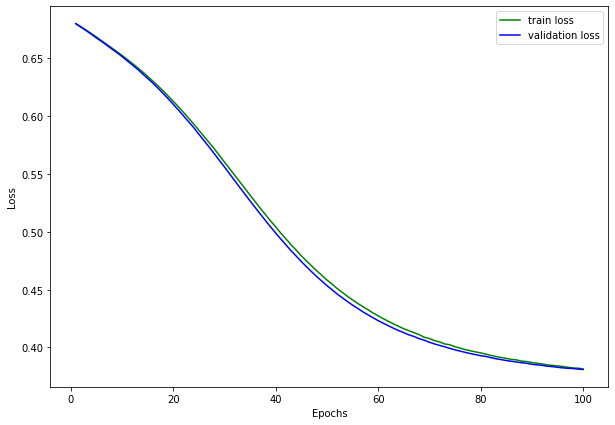

In [19]:
plt.figure(figsize=(10, 7))
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(hist_vloss)+1), hist_vloss, color='blue', linestyle='-', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

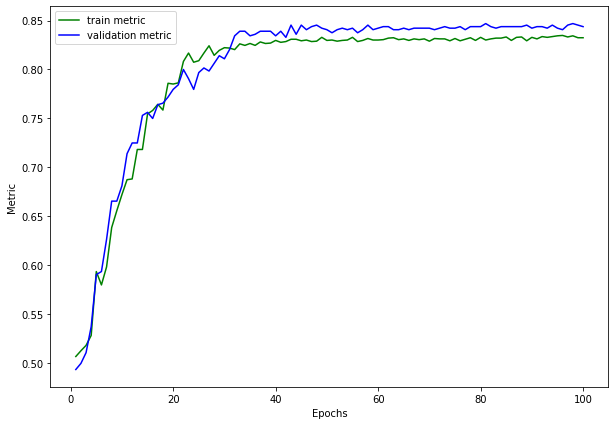

In [18]:
# plot history 
plt.figure(figsize=(10, 7))
plt.plot(range(1,len(hist_metric)+1),hist_metric, color='green', linestyle='-', label='train metric')
plt.plot(range(1,len(hist_vmetric)+1),hist_vmetric, color='blue', linestyle='-', label='validation metric')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()

In [20]:
#test the trained model 

model.to(torch.device("cpu"))

X_test_pt = X_test_pt.type(torch.float).to(torch.device("cpu"))
res = model(X_test_pt)

In [21]:
print('Test accuracy: ',accuracy(res,Y_test_pt))

Test accuracy:  0.83
